In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [13]:
def gen_series(N):
    for i in range(1000,N+1000):
        #Enter your own series formula here
        x = i*i + i
        yield x  

In [23]:
series = gen_series(1000)
df = pd.DataFrame(series)
dataset = df.values
dataset = df.astype('float32')

In [24]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_normalized = scaler.fit_transform(dataset)

In [25]:
# split into train and test sets
train_size = int(len(dataset_normalized) * 0.67)
test_size = len(dataset_normalized) - train_size
train, test = dataset_normalized[0:train_size,:], dataset_normalized[train_size:len(dataset_normalized),:]
print(len(train), len(test))

670 330


In [26]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [27]:
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [28]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0062
Epoch 2/100
 - 1s - loss: 1.5528e-04
Epoch 3/100
 - 1s - loss: 9.0782e-05
Epoch 4/100
 - 1s - loss: 4.3489e-05
Epoch 5/100
 - 1s - loss: 1.5390e-05
Epoch 6/100
 - 1s - loss: 6.4642e-06
Epoch 7/100
 - 1s - loss: 5.5377e-06
Epoch 8/100
 - 1s - loss: 5.8263e-06
Epoch 9/100
 - 1s - loss: 5.5216e-06
Epoch 10/100
 - 1s - loss: 5.9098e-06
Epoch 11/100
 - 1s - loss: 6.1957e-06
Epoch 12/100
 - 1s - loss: 5.4138e-06
Epoch 13/100
 - 1s - loss: 5.3518e-06
Epoch 14/100
 - 1s - loss: 4.0609e-06
Epoch 15/100
 - 1s - loss: 3.4378e-06
Epoch 16/100
 - 1s - loss: 2.6344e-06
Epoch 17/100
 - 1s - loss: 1.6031e-06
Epoch 18/100
 - 1s - loss: 1.1377e-06
Epoch 19/100
 - 1s - loss: 1.1084e-06
Epoch 20/100
 - 1s - loss: 5.8988e-07
Epoch 21/100
 - 1s - loss: 4.6989e-07
Epoch 22/100
 - 1s - loss: 6.3847e-07
Epoch 23/100
 - 1s - loss: 9.5875e-07
Epoch 24/100
 - 1s - loss: 2.8516e-06
Epoch 25/100
 - 1s - loss: 1.0238e-07
Epoch 26/100
 - 1s - loss: 8.2033e-07
Epoch 27/100
 - 1s - loss

In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1470.46 RMSE
Test Score: 41657.38 RMSE


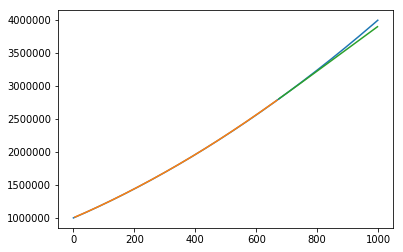

In [31]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset_normalized))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()